In [1]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
# import datetime
import zipfile
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [2]:
out_path_csv = 'data/lakestats_methods_paper.csv'
df = pd.read_csv(out_path_csv)

fn_basin = 'basins/shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = 'basins/shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = 'basins/shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = 'basins/shapefiles/GroundingLine_Antarctica_v02.shp'
fn_merged =  'basins/shapefiles/ANT_basins_merged.shp'
fn_thresh = 'basins/shapefiles/ANT_basins_thresh1000.shp'

ant_gdf_basin = gpd.read_file(fn_basin)
ant_gdf_shelf = gpd.read_file(fn_shelf)
ant_gdf_coast = gpd.read_file(fn_coast)
ant_gdf_ground = gpd.read_file(fn_ground)
ant_gdf_merged = gpd.read_file(fn_merged)
ant_gdf_thresh = gpd.read_file(fn_thresh)

fn_basin = 'basins/shapefiles/Greenland_Basins_PS_v1.4.2.shp'
fn_merged = 'basins/shapefiles/GRE_basins_merged.shp'
fn_thresh = 'basins/shapefiles/GRE_basins_thresh2000.shp'
gre_gdf_basin = gpd.read_file(fn_basin)
gre_gdf_basin['geometry'] = gre_gdf_basin.geometry.buffer(1)
gre_gdf_merged = gpd.read_file(fn_merged)
gre_gdf_thresh = gpd.read_file(fn_thresh)

gre_bound = gre_gdf_basin.dissolve().boundary
ant_bound = ant_gdf_basin.dissolve().boundary

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = '#0692cf'

def plot_region(region, meltseasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
        leg_loc = 'upper left'
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, axs = plt.subplots(figsize=[6,6], nrows=1, ncols=2)
        leg_loc = 'upper right'

    
    dfl = df[df.basin_name == region]
    axs = axs.flatten()
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
            
        scattlabel = r'ICESat-2 lakes: $%i$ total' % len(dfs)
        if region == 'CW':
            scattlabel = scattlabel.replace(':', ':\n')
        scatt = ax.scatter(gdfs.x, gdfs.y, s=2, c='r', alpha=1, zorder=100, label=scattlabel)

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason, fontsize=14)

        patchlabel = r'Landsat melt extent: $%.1f$ km$^2$' % total_area
        if region == 'CW':
            patchlabel = patchlabel.replace(':', ':\n').replace('Landsat ', 'Landsat\n')
        melt_patch = mpatches.Patch(color=melt_color, label=patchlabel)
        ax.legend(handles=[scatt,melt_patch], loc=leg_loc, fontsize=7)
    
    fig.tight_layout()
    fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

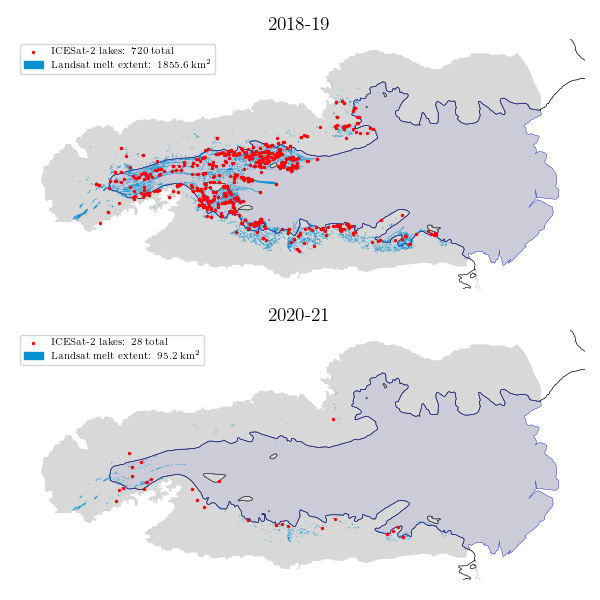

In [4]:
plot_region(region='B-C', meltseasons=['2018-19', '2020-21'])

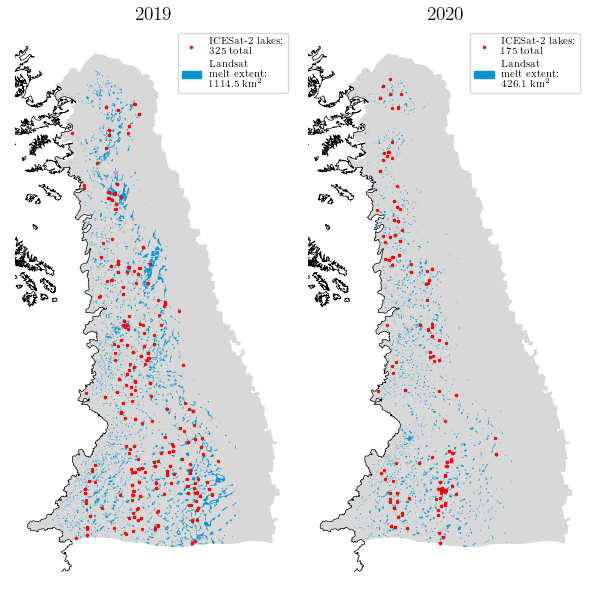

In [5]:
plot_region(region='CW', meltseasons=['2019', '2020'])

In [6]:

out_path_csv = 'data/lakestats_methods_paper_depth_update.csv'
df = pd.read_csv(out_path_csv)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = (0.5,0.5,0.5)

def plot_region(region, meltseasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
        leg_loc = 'upper left'
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, axs = plt.subplots(figsize=[6,6], nrows=1, ncols=2)
        leg_loc = 'upper right'

    
    dfl = df[df.basin_name == region]
    axs = axs.flatten()
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
            
        scattlabel = r'ICESat-2 lakes: $%i$ total' % len(dfs)
        if region == 'CW':
            scattlabel = scattlabel.replace(':', ':\n')
        gdfs = gdfs.sort_values(by='depth_95th_pctl')
        scatt = ax.scatter(gdfs.x, gdfs.y, s=4, c=gdfs.depth_95th_pctl, vmin=0, vmax=5, cmap=cmc.batlow_r,
                           alpha=1, zorder=100, label=scattlabel)

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason, fontsize=14)

        patchlabel = r'Landsat melt extent: $%.1f$ km$^2$' % total_area
        if region == 'CW':
            patchlabel = patchlabel.replace(':', ':\n').replace('Landsat ', 'Landsat\n')
        melt_patch = mpatches.Patch(color=melt_color, label=patchlabel)
        ax.legend(handles=[scatt,melt_patch], loc=leg_loc, fontsize=7)
    
    fig.tight_layout()
    fig.savefig('plots/methods_selection_depth_%s.jpg' % region, dpi=600)

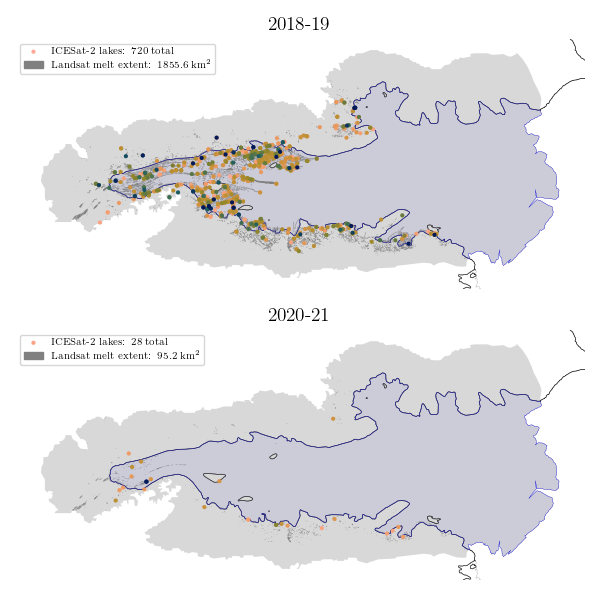

In [7]:
plot_region(region='B-C', meltseasons=['2018-19', '2020-21'])

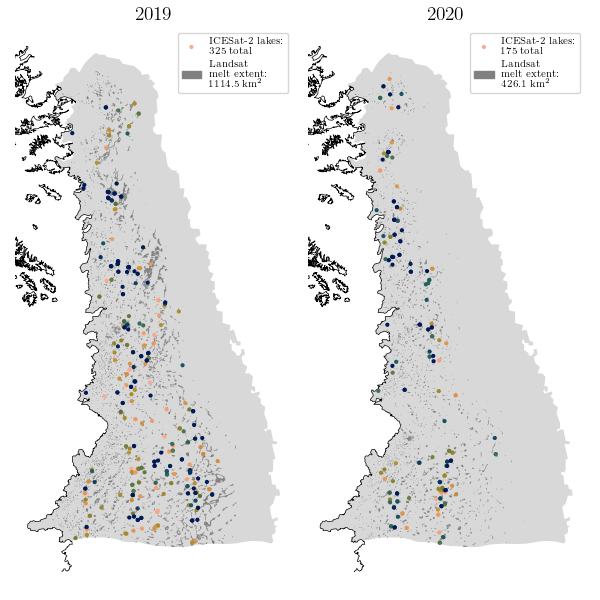

In [8]:
plot_region(region='CW', meltseasons=['2019', '2020'])

In [22]:
out_path_csv = 'data/lakestats_methods_paper_depth_update.csv'
df = pd.read_csv(out_path_csv)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = (0.5,0.5,0.5)

def plot_region(region, meltseasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
        leg_loc = 'upper left'
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, ax = plt.subplots(figsize=[6,8], nrows=1, ncols=1)
        leg_loc = 'upper right'

    
    dfl = df[df.basin_name == region]
    #axs = axs.flatten()
    hdls = []
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        #ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
            
        scattlabel = r'ICESat-2 lakes: $%i$ total' % len(dfs)
        if region == 'CW':
            scattlabel = scattlabel.replace(':', ':\n')
        gdfs = gdfs.sort_values(by='depth_95th_pctl')

        fc = 'C%s'%i if i%2==1 else 'none'
        ec = 'C%s'%i if i%2==0 else 'none'
        mk = 'o' if i%2==0 else 'x'
        scatt = ax.scatter(gdfs.x, gdfs.y, s=10, facecolor=fc, edgecolor=ec, marker=mk,
                           alpha=1, zorder=100+i, label=scattlabel, lw=1)
        hdls.append(scatt)

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason, fontsize=14)

        patchlabel = r'Landsat melt extent: $%.1f$ km$^2$' % total_area
        if region == 'CW':
            patchlabel = patchlabel.replace(':', ':\n').replace('Landsat ', 'Landsat\n')
        melt_patch = mpatches.Patch(color=melt_color, label=patchlabel)
        ax.legend(handles=hdls+[melt_patch], loc=leg_loc, fontsize=7)
    
    fig.tight_layout()
    fig.savefig('plots/methods_selection_depth_%s.jpg' % region, dpi=600)

/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_91128/19569020.py:55: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatt = ax.scatter(gdfs.x, gdfs.y, s=10, facecolor=fc, edgecolor=ec, marker=mk,


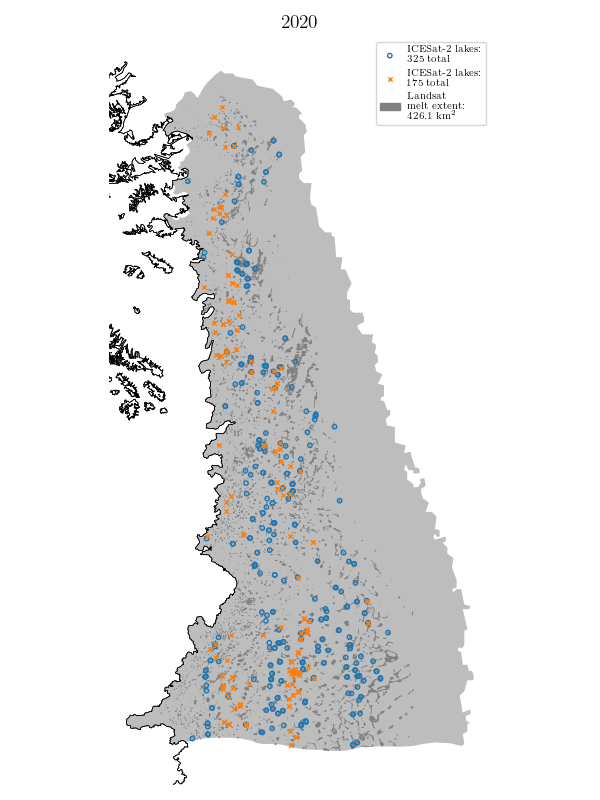

In [23]:
plot_region(region='CW', meltseasons=['2019', '2020'])

In [ ]:
min_area = 0.05
ext = gpd.read_file('region_shapefiles/extents/B-C_extent_2018_19.geojson')\
    .explode(index_parts=False).to_crs('EPSG:3031')
patch_areas = ext.geometry.area / 1e6
ext = ext[patch_areas > min_area].simplify(60)

In [ ]:
df_bc = df[df.basin_name=='B-C']
df_bc.fn_only.iloc[0]

In [ ]:
! ls data/lakes/*_AIS_2018-19_simplified_ANT_1000_East_B-C_* | wc -l
! ls data/lakes/*_AIS_2020-21_simplified_ANT_1000_East_B-C_* | wc -l

In [ ]:
# ! cp ../IceLakesRun2/detection_out_data/*_AIS_2018-19_simplified_ANT_1000_East_B-C_* ../IceLakesRun2/methods_data
# ! cp ../IceLakesRun2/detection_out_data/*_AIS_2020-21_simplified_ANT_1000_East_B-C_* ../IceLakesRun2/methods_data

In [ ]:
df_bc = df[df.basin_name=='CW']
df_bc.fn_only.iloc[0]

In [ ]:
! ls data/lakes/*_GrIS_2019_simplified_GRE_2000_CW_* | wc -l
! ls data/lakes/*_GrIS_2020_simplified_GRE_2000_CW_* | wc -l

In [ ]:
# ! cp ../IceLakesRun2/detection_out_data/*_GrIS_2019_simplified_GRE_2000_CW_* ../IceLakesRun2/methods_data
# ! cp ../IceLakesRun2/detection_out_data/*_GrIS_2020_simplified_GRE_2000_CW_* ../IceLakesRun2/methods_data

In [ ]:
r'Landsat melt extent: $%.1f$ km$^2$' % total_area

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = '#0692cf'

def plot_region(region, melt_seasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, axs = plt.subplots(figsize=[6,6], nrows=1, ncols=2)

    
    dfl = df[df.basin_name == region]
    axs = axs.flatten()
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        print(meltseason, len(dfs))
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
    
        scatt = ax.scatter(gdfs.x, gdfs.y, s=2, c='r', alpha=1, zorder=100, 
                           label=r'ICESat-2 lakes: $%i$ total' % len(dfs))

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason)
    
        melt_patch = mpatches.Patch(color=melt_color, label=r'Landsat melt extent: $%.1f$ km$^2$' % total_area)
        ax.legend(handles=[scatt,melt_patch], loc='upper left', fontsize=8)
    
    fig.tight_layout()
    # fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
region = 'B-C'
min_area = 0.01
base_crs = 'EPSG:3031'
meltseasons = ['2018-19', '2020-21']
melt_color = '#0692cf'

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
axs = axs.flatten()

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    scatt = ax.scatter(gdfs.x, gdfs.y, s=2, c='r', alpha=1, zorder=100, 
                       label=r'ICESat-2 lakes: $%i$ total' % len(dfs))

    ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
    .explode(index_parts=False).to_crs(base_crs)
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s' % meltseason)

    melt_patch = mpatches.Patch(color=melt_color, label=r'Landsat melt extent: $%.1f$ km$^2$' % total_area)
    ax.legend(handles=[scatt,melt_patch], loc='upper left', fontsize=8)

fig.tight_layout()
# fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
region = 'B-C'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[8,6], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    # ax.scatter(gdfs.x, gdfs.y, s=0.5, c='r', alpha=0.5, zorder=100)

    ext = gpd.read_file('region_shapefiles/extents/B-C_extent_%s.geojson' % meltseason.replace('-', '_'))\
    .explode(index_parts=False).to_crs('EPSG:3031')
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext.buffer(100).simplify(100).plot(ax=ax, color='#0692cf')    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %.1f km^2' % (meltseason, total_area))
    # ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))
    ax.set_title('%s: %i lakes | %.1f km^2' % (meltseason,  len(dfs), total_area))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'Hp-I'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[5.5,8], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    ant_gdf_shelf.plot(color='blue', alpha=0.1, ax=ax, lw=0)
    ant_gdf_shelf.exterior.plot(color='blue', ax=ax, lw=0.5)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=3, c='r', alpha=0.5, zorder=100)
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

# out_data_dir = 'region_shapefiles/'
# region_thresh.to_file('%s%s.shp' % (out_data_dir,region))
# searchfor = '%s.' % region
# lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
#             if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f)]
# lista_files.sort()
# print(lista_files)
# with zipfile.ZipFile('%s%s.zip' % (out_data_dir, region), 'w') as zipMe:        
#     for file in lista_files:
#         zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)


In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'CW'
meltseasons = ['2019']
base_crs = 'EPSG:3413'
meltseasons = []
for y in np.arange(2019,2024):
    meltseasons.append(str(y))

region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
dfl = df[df.basin_name == region]

# fig, axs = plt.subplots(figsize=[5,12], nrows=5)
fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=3)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    gre_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=0.5, c='r', alpha=0.5, zorder=100)
    
    ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
    .explode(index_parts=False).to_crs(base_crs)
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext.buffer(200).simplify(100).plot(ax=ax, color='#0692cf')    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %.1f km^2' % (meltseason, total_area))
    # ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))
    ax.set_title('%s: %i lakes | %.1f km^2' % (meltseason,  len(dfs), total_area), fontsize=8)

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"SUBREGION1": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'C-Cp'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[8,6], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=1, c='r', alpha=0.5, zorder=100)
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

base_tiled.to_file('%s%s.shp' % (out_data_dir,region))
searchfor = '%s.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_base = gpd.read_file('%s%s.shp' % (out_data_dir,region))
tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)
tiled_base.boundary.plot(color='r', ax=ax, lw=2)